In [1]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from helper import compute_ats_bounding_boxes, compute_ts_road_map

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [3]:
# All the images are saved in image_folder
# All the labels are saved in the annotation_csv file
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

# Labeled dataset

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
labeled_scene_index = np.arange(106, 134)
train_inds = labeled_scene_index[:23]
val_inds = labeled_scene_index[23:]

In [6]:
# The labeled dataset can only be retrieved by sample.
# And all the returned data are tuple of tensors, since bounding boxes may have different size
# You can choose whether the loader returns the extra_info. It is optional. You don't have to use it.

transform_train = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ]), 
                                AddGaussianNoise(0., 0.1)])
transform_val = transforms.Compose([torchvision.transforms.Resize((256,256)),
                                transforms.ToTensor(), 
                                transforms.Normalize([ 0.485, 0.456, 0.406 ],[ 0.229, 0.224, 0.225 ])])

labeled_trainset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_inds,
                                  transform=transform_train,
                                  extra_info=True
                                 )
labeled_valset = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_inds,
                                  transform=transform_val,
                                  extra_info=True
                                 )
trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=2, shuffle=True, num_workers=2, collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=1,shuffle=False, num_workers=2)
pseudo_valloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=1,shuffle=False, num_workers=2)

In [64]:
sample, target, road_image, extra = iter(trainloader).next()
print(torch.stack(sample).shape)

torch.Size([2, 6, 3, 256, 256])


In [62]:
import io
import matplotlib
from PIL import Image
import matplotlib.pyplot as plt
#matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 800

def draw_filled_box(ax, corners, color):
    point_squence = torch.stack([corners[:, 0], corners[:, 1], corners[:, 3], corners[:, 2], corners[:, 0]])
    
    # the corners are in meter and time 10 will convert them in pixels
    # Add 400, since the center of the image is at pixel (400, 400)
    # The negative sign is because the y axis is reversed for matplotlib
    ax.fill(point_squence.T[0] * 10 + 400, -point_squence.T[1] * 10 + 400, color=color)
    
def generate_image(target):
    # The center of image is 400 * 400
    fig, ax = plt.subplots()
    ax.axis('off')
    ax.set_xlim(0,800)
    ax.set_ylim(0,800)
    for t in target['bounding_box']:
        draw_filled_box(ax, t, color='black') 
    plt.close(fig)
    # convert to PIL Image object
    buffer = io.BytesIO()
    fig.savefig(buffer, format='png', dpi=200, bbox_inches='tight')
    buffer.seek(0)
    im = Image.open(buffer).convert('L').transpose(Image.FLIP_TOP_BOTTOM)
    img_arr = np.asarray(im)
    buffer.close()
    return img_arr

def get_target_array(targets):
    n = len(targets)
    array_targets = []
    for idx, target in enumerate(targets):
        array_targets.append(generate_image(target))
    t = torch.tensor(array_targets)/255
    return 1-t

In [65]:
t = get_target_array(target)

In [66]:
t.shape

torch.Size([2, 547, 824])

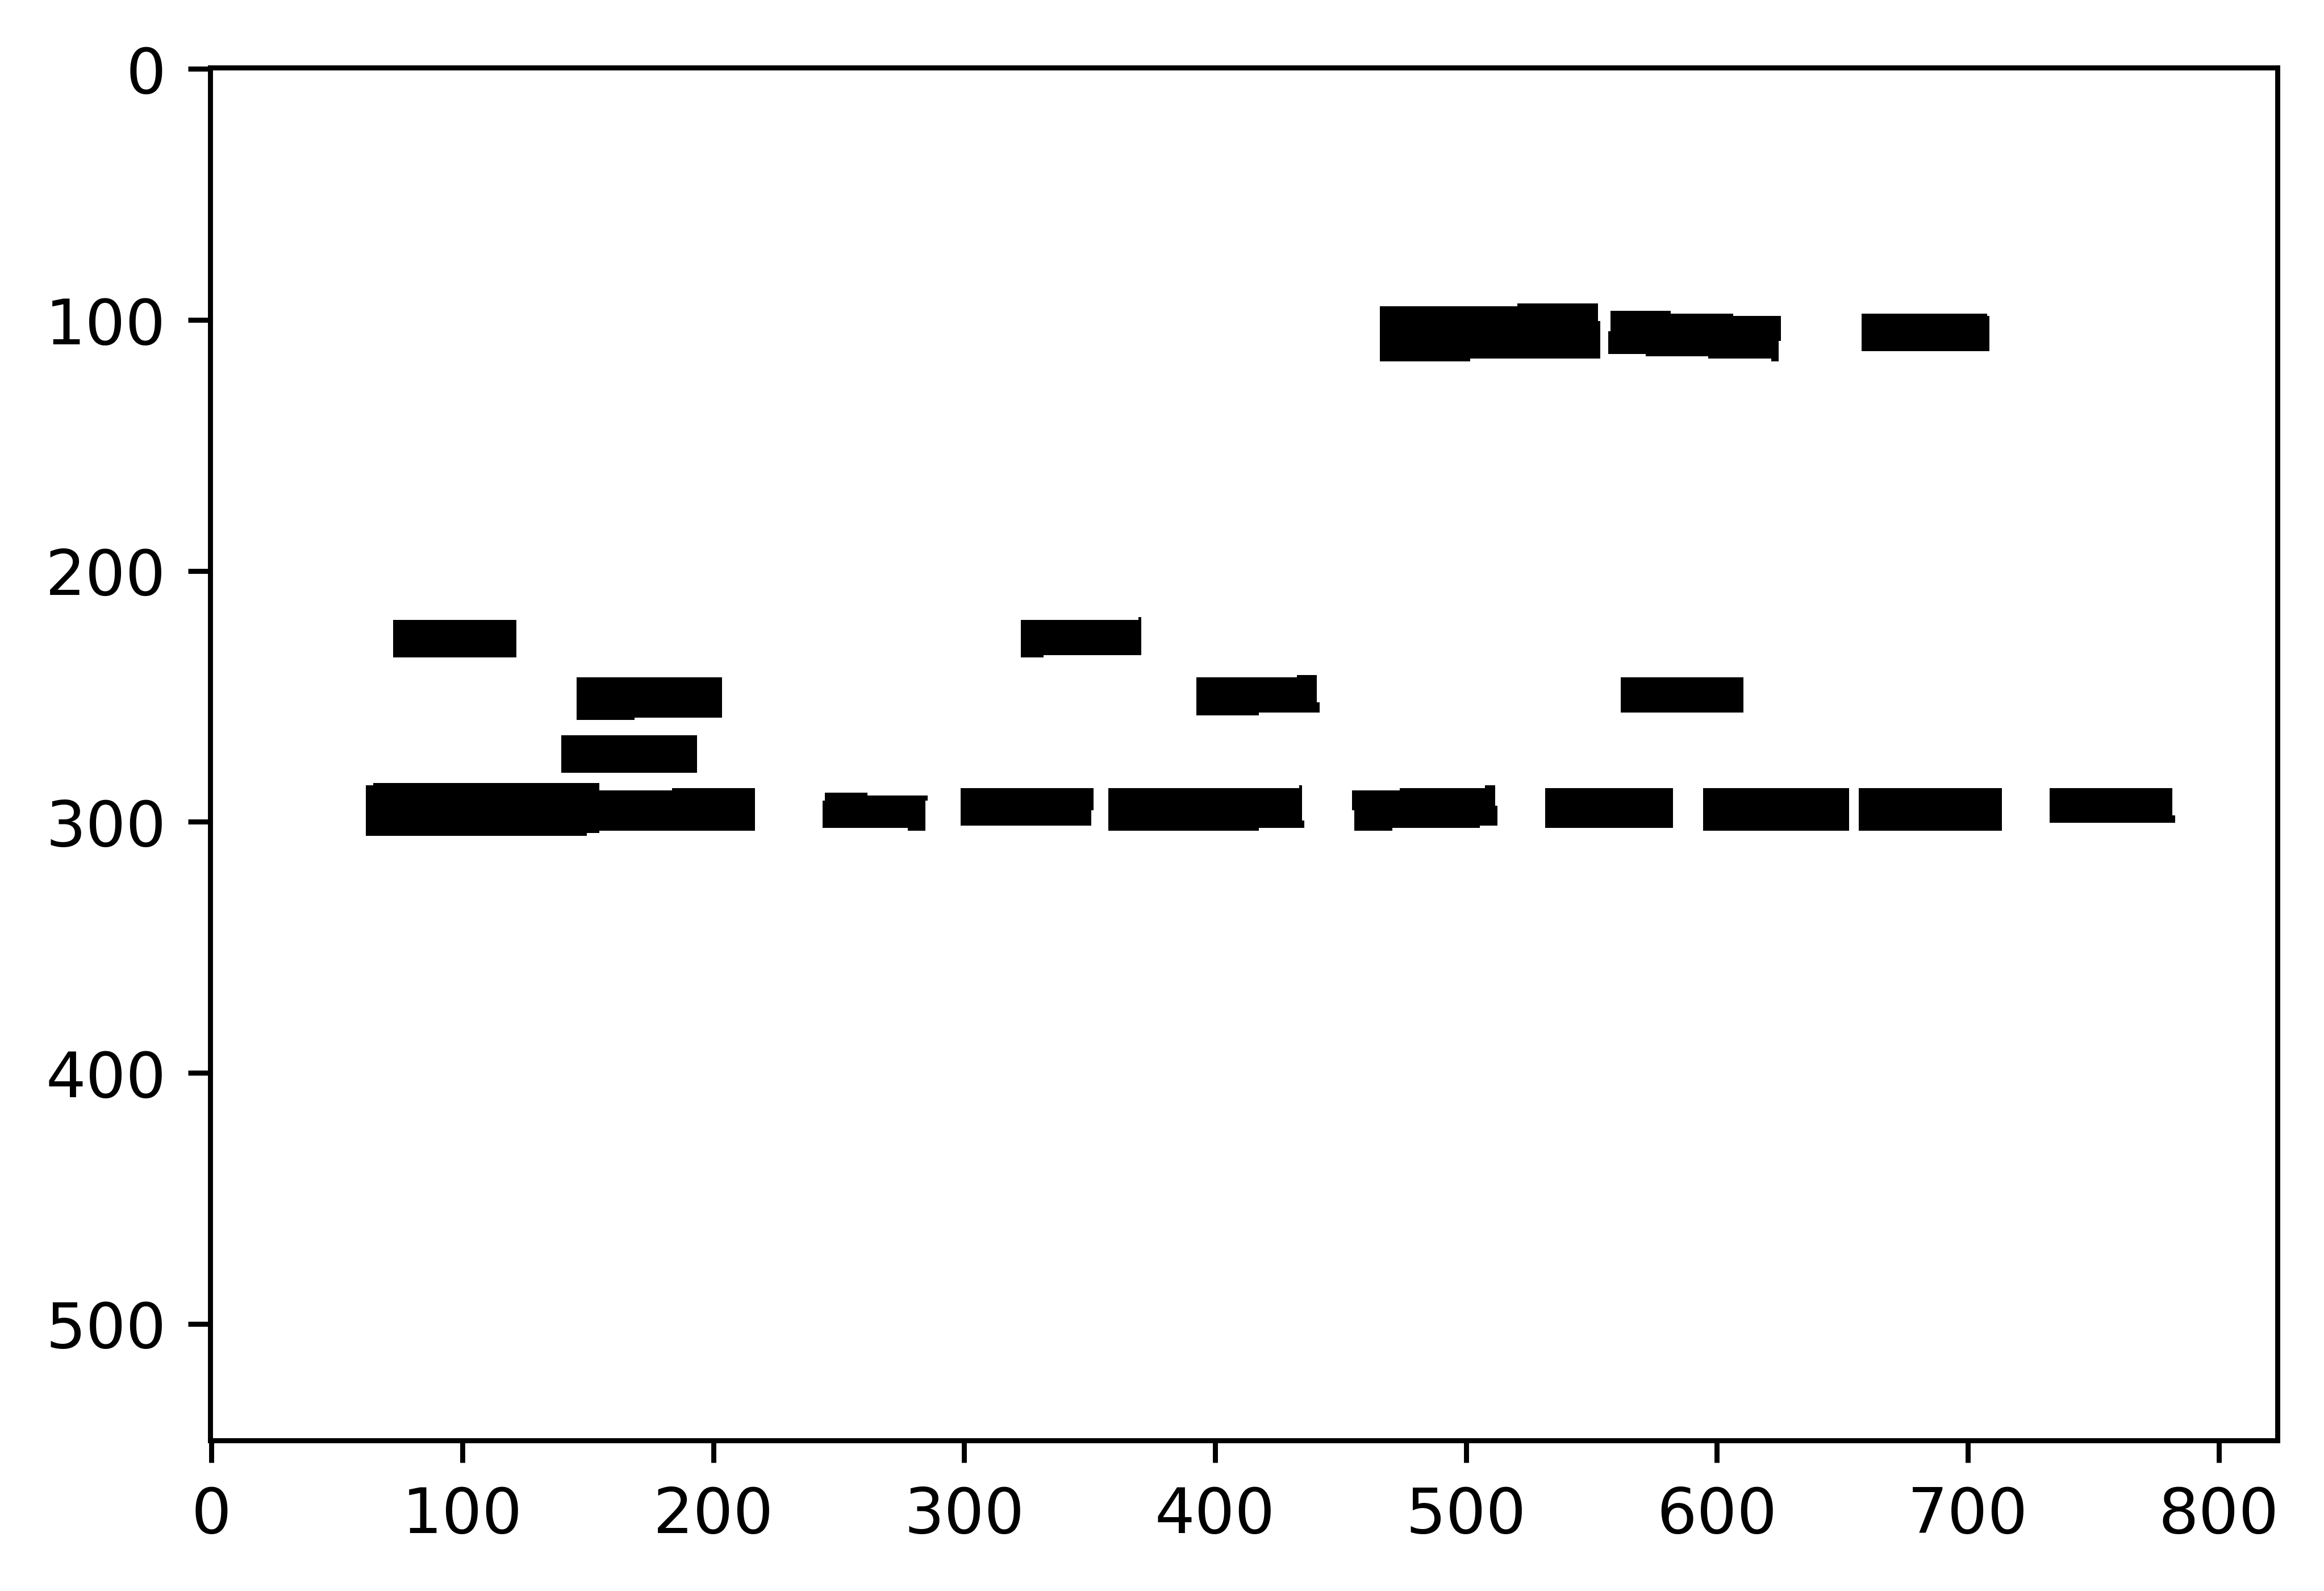

In [67]:
plt.imshow(t[0].numpy(),cmap='binary')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


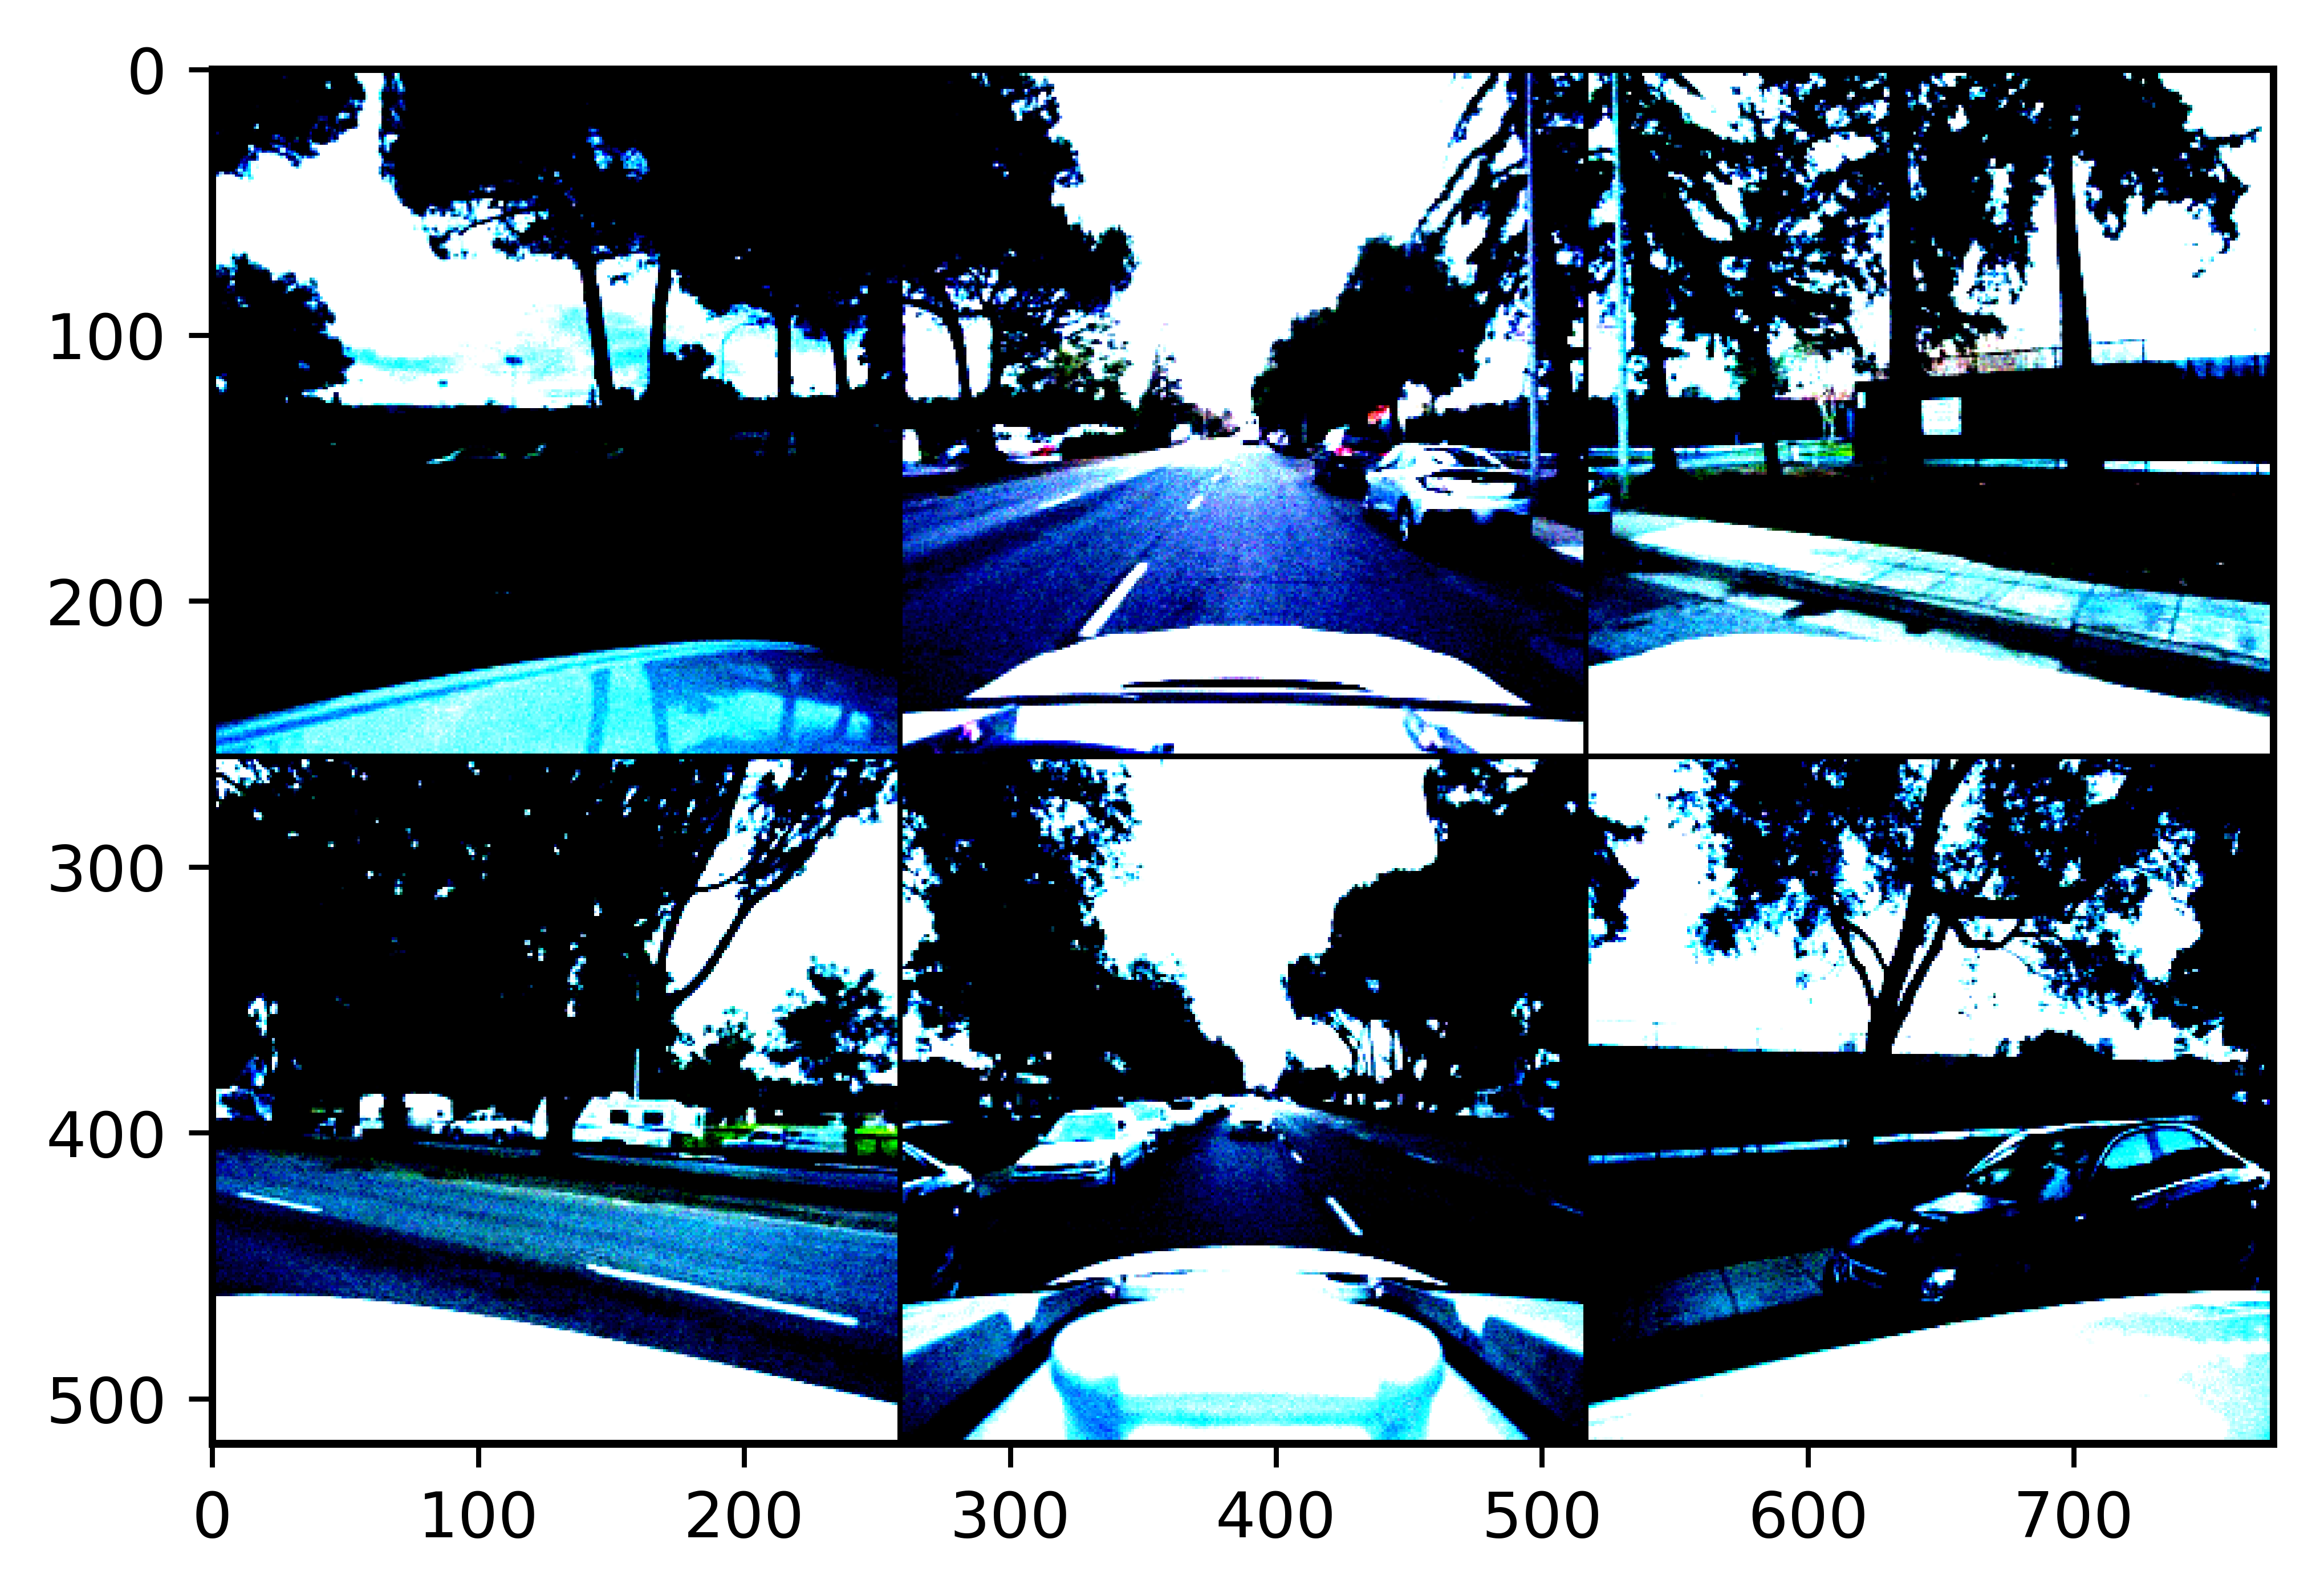

In [61]:
plt.imshow(torchvision.utils.make_grid(sample[0], nrow=3).numpy().transpose(1, 2, 0))

## Modeling 

In [10]:
import torchvision.models as models
import copy

In [11]:
class UNet(nn.Module):
    def ConvBlock(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, use_bias = False):
        block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, 
                                        stride, padding, bias = use_bias),
                              nn.BatchNorm2d(out_channels),
                              nn.ReLU(True)
                             )
        return block
    
    def Bridge(self, in_channels, out_channels):
        bridge = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                               self.ConvBlock(out_channels, out_channels)
                              )
        return bridge
    
    def UpsampleBlock(self, in_channels, out_channels, use_bias=False):
        upsample = nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, bias=use_bias),
                                 nn.BatchNorm2d(out_channels),
                                 nn.ReLU(True))
        return upsample
        
    def UpsampleConv(self, in_channels, out_channels):
        upsample_conv = nn.Sequential(self.ConvBlock(in_channels, out_channels),
                                      self.ConvBlock(out_channels, out_channels))    
        return upsample_conv
        
        
    def __init__(self, num_classes, output_size, encoder='resnet18', pretrained = False, depth = 6):
        '''
        num_classes: Number of channels/classes for segmentation
        output_size: Final output size of the image (H*H)
        encoder: Supports resnet18, resnet 34 and resnet50 architectures
        pretrained: For loading a pretrained resnet model as encoder
        '''
        super(UNet,self).__init__()  
        self.depth = depth
        self.num_classes = num_classes
        self.output_size = output_size
        
        self.resnet = torchvision.models.resnet50(pretrained=pretrained) if encoder == "resnet50" else\
                            torchvision.models.resnet34(pretrained=pretrained) if encoder == "resnet34" else\
                            torchvision.models.resnet18(pretrained=pretrained)
        
        self.resnet_layers = list(self.resnet.children())
        self.n = 2048 if encoder == "resnet50" else 512
        
        self.input_block = nn.Sequential(*self.resnet_layers)[:3]
        self.input_block[0] = nn.Conv2d(18, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.input_pool = self.resnet_layers[3]
        self.down_blocks = nn.ModuleList([i for i in self.resnet_layers if isinstance(i, nn.Sequential)])

        self.bridge = self.Bridge(self.n, self.n)
        
        self.up_blocks = nn.ModuleList([self.UpsampleBlock(self.n,self.n//2)[0],
                                        self.UpsampleBlock(self.n//2,self.n//4)[0],
                                        self.UpsampleBlock(self.n//4,self.n//8)[0],
                                        self.UpsampleBlock(self.n//8,self.n//16)[0],
                                        self.UpsampleBlock(self.n//16,self.n//32)[0]])
        
        self.up_conv = nn.ModuleList([self.UpsampleConv(self.n,self.n//2),
                                      self.UpsampleConv(self.n//2,self.n//4),
                                      self.UpsampleConv(self.n//4,self.n//8),
                                      self.UpsampleConv(self.n//16 + 64,self.n//16),
                                      self.UpsampleConv(self.n//32 + 18,self.n//32)])
        
        self.final_upsample_1 = self.UpsampleBlock(self.n//32,self.n//64)
        self.final_upsample_2 = self.UpsampleBlock(self.n//64,self.num_classes)[0]
        
        self.final_pooling = nn.AdaptiveMaxPool2d(output_size=self.output_size)

    def forward(self, x):
        skip_conn = {"layer_0": x}
        x = self.input_block(x)
        skip_conn[f"layer_1"] = x
        x = self.input_pool(x)

        for i, block in enumerate(self.down_blocks, 2):
            x = block(x)
            if i != (self.depth - 1):
                skip_conn[f"layer_{i}"] = x
            
        x = self.bridge(x)

        #x = torch.sum(x,dim=0)
        #x = x.repeat((6,1,1,1))

        for i, block in enumerate(self.up_blocks):
            key = f"layer_{self.depth - i - 2}"            
            x = block(x)
            x = torch.cat([x, skip_conn[key]],1)
            x = self.up_conv[i](x)

        del skip_conn
        
        #x = torch.sum(x,dim=0)
        x = self.final_upsample_1(x)#.unsqueeze(0))
        x = self.final_upsample_2(x)
        x = self.final_pooling(x)
        x = x.view(-1,self.output_size,self.output_size)
        x = torch.sigmoid(x)
        return x

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [13]:
class DetectionModel(nn.Module):
    def __init__(self,Unet):
        super(DetectionModel,self).__init__()
        self.unet = UNet(num_classes=1, output_size=800, encoder="resnet34", pretrained = False).to(device)
        
        self.model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

        # replace the classifier with a new one, that has
        # num_classes which is user-defined
        num_classes = 2  # 1 class (person) + background
        # get number of input features for the classifier
        in_features = self.model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        self.model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    def forward(self,img,targets = None):
        if self.training:
            batch_size = img.shape[0]
            segmented = self.unet(img).unsqueeze(1)
            d = segmented.device
            #print(segmented.shape)
            targets = [{'boxes':torch.cat((t['bounding_box'][:,:,0],t['bounding_box'][:,:,3]),dim=1).float().to(d)*10+400,'labels':torch.ones(t['category'].shape[0],device=d,dtype=torch.int64)} for t in targets]
            loss = self.model(segmented.repeat(1,3,1,1),targets)
            return loss
        else:
            with torch.no_grad():
                batch_size = img.shape[0]
                segmented = self.unet(img).unsqueeze(1)
                predictions = self.model(segmented.repeat(1,3,1,1))
            return predictions
            
            
        

In [14]:
device = torch.device('cuda:1')
model = DetectionModel(UNet).to(device)
lr = 5e-5
optimizer  = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer  = torch.optim.SGD(model.parameters(), lr=0.0005,momentum=0.9, weight_decay=0.0005)
#scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

In [15]:
def validation(model,val_loader,device):
    model.eval()
    with torch.no_grad():
        tse_bbox = 0.
        total = 0.
        for i,(sample, target, road_image,extra) in enumerate(val_loader):
            total+=1.0  
            input_img = sample.to(device)
            #input_img = torch.stack(sample).to(device)
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            output = model(input_img.view(batch_size,-1,height,width))
            t = (output[0]['boxes']/10)-40
            cars = torch.zeros((t.shape[0],2,4),device=device)
            cars[:,0,0],cars[:,0,2],cars[:,0,1],cars[:,0,3] = t[:,0],t[:,0],t[:,2],t[:,2]
            cars[:,1,0],cars[:,1,2],cars[:,1,1],cars[:,1,3] = t[:,1],t[:,3],t[:,1],t[:,3]
            #print(target['bounding_box'][0].shape)
            if cars.shape[0]>0:
                tse_bbox+=float(compute_ats_bounding_boxes(cars.double(),target['bounding_box'][0].to(device)))
        return (tse_bbox/total)

In [16]:
def train(model,train_loader,val_loader,optimizer,device,num_epochs = 10):
    max_val = 0
    c_point = 420
    #model.load_state_dict(torch.load('model_unet_sgd_bce.pth'))
    for epoch in range(1,num_epochs+1):
        model.train()
        avg_train_loss_bbox = 0
        for i,(sample, target, road_image, extra) in enumerate(train_loader):
            input_img = torch.stack(sample).to(device)
            batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
            optimizer.zero_grad()
            loss_dict = model(input_img.view(batch_size,-1,height,width),target)
            #print(loss_dict)
            loss = loss_dict['loss_classifier']+loss_dict['loss_box_reg']+loss_dict['loss_objectness']
            print(loss)
            avg_train_loss_bbox+=loss.item()
            loss.backward()
            optimizer.step()
#             if (i+1)%c_point==0:
#                 print('epoch: {} | train loss: {}'.format(epoch,
#                                                           round(avg_train_loss_bbox/c_point,2)))
#                 avg_train_loss_bbox = 0
            if (i+1)%c_point==0:
                val_tse_bbox = validation(model,val_loader,device)
                print('epoch: {} | step: {}/{} | train loss bbox: {} | val tse bbox: {}'.format(epoch,
                                                                                      (i+1)//c_point,
                                                                                      len(train_loader)//c_point,
                                                                                      round(avg_train_loss_bbox/c_point,2),
                                                                                      round(val_tse_bbox,2)))
                model.train()
                avg_train_loss_bbox = 0
                if val_tse_bbox>max_val:
                    print('--Saving--')
                    torch.save(model.state_dict(),'model_detection_sgd.pth')
                    max_val = val_tse_bbox
        #scheduler.step()
            

In [17]:
train(model,trainloader,valloader,optimizer,device,num_epochs=20)

tensor(1.4158, device='cuda:1', grad_fn=<AddBackward0>)
tensor(1.2494, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.9871, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.6949, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.6164, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.7112, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.5631, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.4970, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.2568, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0950, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.8072, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.3701, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0893, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1218, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1083, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1222, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0494, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0508, device='cuda:1', grad_fn=<AddBack

tensor(0.0691, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0070, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0215, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1266, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0264, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0476, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0334, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0649, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0696, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0313, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0340, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0556, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0290, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0393, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0449, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0464, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0357, device='cuda:1', grad_fn=<AddBack

tensor(0.0357, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0653, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0290, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0305, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0211, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0175, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0307, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0237, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0473, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0362, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0093, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1078, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0106, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0215, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0067, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0875, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0260, device='cuda:1', grad_fn=<AddBack

tensor(0.0193, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0138, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0326, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0066, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0198, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0059, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0390, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0108, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0074, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0064, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0164, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0592, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0027, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0183, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0322, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1155, device='cuda:1', grad_fn=<AddBack

tensor(0.0025, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0100, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0260, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1060, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0317, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0564, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0545, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0153, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0164, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0205, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0189, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0213, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0148, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0436, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0166, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0094, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0301, device='cuda:1', grad_fn=<AddBack

tensor(0.0187, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0267, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0495, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0180, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0537, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0344, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0637, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0188, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0256, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0415, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0133, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0487, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0310, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0284, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0254, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0279, device='cuda:1', grad_fn=<AddBack

tensor(0.0179, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0155, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1002, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0477, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0425, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0191, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0375, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0365, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0102, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0125, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0149, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0266, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0213, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0403, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0053, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0252, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:1', grad_fn=<AddBack

tensor(0.0119, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0055, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0554, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0122, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0389, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0046, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0309, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0145, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0295, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:1', grad_fn=<AddBack

tensor(0.0192, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0334, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0230, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0122, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0398, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0230, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0147, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0265, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0109, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0145, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0141, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0295, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0217, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0320, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0209, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0153, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0441, device='cuda:1', grad_fn=<AddBack

tensor(0.0115, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0408, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0294, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0188, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0332, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0456, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0166, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0344, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0202, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0316, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0411, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0091, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0100, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0113, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0118, device='cuda:1', grad_fn=<AddBack

tensor(0.0383, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0317, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0087, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0121, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0101, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0150, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0115, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0272, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0224, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0211, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0233, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0781, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0158, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0177, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0308, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0630, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0263, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0230, device='cuda:1', grad_fn=<AddBack

tensor(0.0077, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0212, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0168, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0233, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0158, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0219, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0258, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0467, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0070, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0202, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0172, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0093, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0067, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0196, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0261, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0412, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0120, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0334, device='cuda:1', grad_fn=<AddBack

tensor(0.0046, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0094, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0019, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0951, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0231, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0080, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0369, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0465, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0198, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0169, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0141, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0075, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0137, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0173, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0187, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0201, device='cuda:1', grad_fn=<AddBack

tensor(0.0219, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0408, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0080, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0515, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0332, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0507, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0118, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0366, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0197, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0089, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0342, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0258, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0149, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0409, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0146, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0069, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0124, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0507, device='cuda:1', grad_fn=<AddBack

tensor(0.0274, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0303, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0186, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0149, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0201, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0148, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0113, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0142, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0053, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0094, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0108, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0037, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0109, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0108, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0346, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0225, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0051, device='cuda:1', grad_fn=<AddBack

tensor(0.0135, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0163, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0574, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0139, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0214, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0203, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0665, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0340, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0287, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0058, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0214, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0546, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0418, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0324, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0360, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0267, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0106, device='cuda:1', grad_fn=<AddBack

tensor(0.0220, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0229, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0228, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0451, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0495, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0339, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0429, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0507, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0130, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0134, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0590, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0303, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0198, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0248, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0123, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0121, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0276, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0260, device='cuda:1', grad_fn=<AddBack

tensor(0.0620, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0401, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0176, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0175, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0276, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0152, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0127, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0109, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0119, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0371, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0103, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0083, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0364, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0165, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0187, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0410, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0204, device='cuda:1', grad_fn=<AddBack

tensor(0.0072, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0254, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0065, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0056, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0377, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0090, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0220, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0097, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0163, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0311, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0237, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0269, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0661, device='cuda:1', grad_fn=<AddBack

tensor(0.0040, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0139, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0519, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0118, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0198, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0242, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0187, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0324, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0146, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0130, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0128, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0089, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0229, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0205, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0738, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0095, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0206, device='cuda:1', grad_fn=<AddBack

tensor(0.0255, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0141, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0028, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0214, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0208, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0124, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0029, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0456, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0347, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0170, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0082, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0180, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0053, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0256, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0294, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0083, device='cuda:1', grad_fn=<AddBack

tensor(0.0087, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0107, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0231, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0077, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0070, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0048, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0151, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0158, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0191, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0185, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0191, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0097, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0209, device='cuda:1', grad_fn=<AddBack

tensor(0.0108, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0133, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0411, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1235, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0415, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0500, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0296, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0199, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0079, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0200, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0625, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0094, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0318, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0255, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0731, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0144, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0106, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0072, device='cuda:1', grad_fn=<AddBack

tensor(0.0665, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0525, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0211, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0227, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0184, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0277, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0102, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0338, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0399, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0707, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0579, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0169, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0467, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0463, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0202, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0458, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0248, device='cuda:1', grad_fn=<AddBack

tensor(0.0192, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0337, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0624, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0520, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0548, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0142, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0384, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0143, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0084, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0134, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0079, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0364, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0076, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0437, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0283, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0167, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0123, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0432, device='cuda:1', grad_fn=<AddBack

tensor(0.0492, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0265, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0236, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0552, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0133, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0137, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0338, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0069, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1370, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0110, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0133, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0166, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0072, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0286, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0177, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:1', grad_fn=<AddBack

tensor(0.0071, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0066, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0098, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0176, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0201, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0111, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0096, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0018, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0132, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0125, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0761, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0546, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0115, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0274, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0177, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0320, device='cuda:1', grad_fn=<AddBack

tensor(0.0163, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0126, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0139, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0659, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0223, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0085, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0120, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0110, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0107, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0215, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0092, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0122, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0031, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0059, device='cuda:1', grad_fn=<AddBack

tensor(0.0037, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0234, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0082, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0264, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0008, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0064, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0151, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0063, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0022, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0084, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0059, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0068, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0489, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0230, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0212, device='cuda:1', grad_fn=<AddBack

tensor(0.0034, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0043, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0102, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0846, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0116, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0114, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0179, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0100, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0135, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0114, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0088, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0170, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0116, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0319, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0061, device='cuda:1', grad_fn=<AddBack

tensor(0.0329, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0150, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0091, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0068, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0381, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0126, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0263, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0131, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0236, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0102, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0123, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0090, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0274, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0231, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0170, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0274, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0264, device='cuda:1', grad_fn=<AddBack

tensor(0.0077, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0064, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0030, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0042, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0016, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0014, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0190, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0114, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0517, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0104, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0062, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0123, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0058, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0157, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0068, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:1', grad_fn=<AddBack

tensor(0.0042, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0009, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0048, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0024, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0025, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0097, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0049, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0050, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0153, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:1', grad_fn=<AddBack

tensor(0.0082, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0150, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0263, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0155, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0081, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0060, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0038, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0255, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0199, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0032, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0199, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0163, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0208, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0148, device='cuda:1', grad_fn=<AddBack

tensor(0.0087, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0034, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0081, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0020, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0088, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0017, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0010, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0021, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0107, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0013, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0011, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0069, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0036, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0073, device='cuda:1', grad_fn=<AddBack

tensor(0.0105, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0007, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0063, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1522, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0141, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0232, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0075, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0221, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0147, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0062, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.1460, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0096, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0157, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0223, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0252, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0169, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0005, device='cuda:1', grad_fn=<AddBackward0>)
tensor(0.0105, device='cuda:1', grad_fn=<AddBack

KeyboardInterrupt: 

In [20]:
model.eval()
with torch.no_grad():
    sample, target, road_image, extra = labeled_trainset[5]
    input_img = sample.unsqueeze(0).to(device)
    #input_img = torch.stack(sample).to(device)
    batch_size,height,width = input_img.shape[0],input_img.shape[-2],input_img.shape[-1]
    output = model(input_img.view(batch_size,-1,height,width))
    t = (output[0]['boxes']/10)-40
    cars = torch.zeros((t.shape[0],2,4),device=device)
    cars[:,0,0],cars[:,0,2],cars[:,0,1],cars[:,0,3] = t[:,0],t[:,0],t[:,2],t[:,2]
    cars[:,1,0],cars[:,1,2],cars[:,1,1],cars[:,1,3] = t[:,1],t[:,3],t[:,1],t[:,3]

In [22]:
cars

tensor([[[-35.2520, -35.2262, -35.2520, -35.2262],
         [-20.6694, -20.6694, -20.5562, -20.5562]],

        [[-34.7730, -34.3694, -34.7730, -34.3694],
         [-18.8532, -18.8532, -18.3756, -18.3756]],

        [[-36.5051, -36.4807, -36.5051, -36.4807],
         [-20.5165, -20.5165, -20.4085, -20.4085]],

        [[-34.1534, -34.1264, -34.1534, -34.1264],
         [-20.7371, -20.7371, -20.6202, -20.6202]],

        [[-37.9382, -37.9165, -37.9382, -37.9165],
         [-20.3174, -20.3174, -20.2161, -20.2161]],

        [[-38.4008, -38.3806, -38.4008, -38.3806],
         [-20.5875, -20.5875, -20.5051, -20.5051]],

        [[-31.7822, -31.3348, -31.7822, -31.3348],
         [-19.2652, -19.2652, -18.7539, -18.7539]],

        [[-35.8478, -35.8237, -35.8478, -35.8237],
         [-20.9047, -20.9047, -20.8133, -20.8133]],

        [[-36.8883, -36.3922, -36.8883, -36.3922],
         [-20.9760, -20.9760, -20.4889, -20.4889]],

        [[-34.5599, -34.0374, -34.5599, -34.0374],
         [-21

In [23]:
target['bounding_box']

tensor([[[-19.3987, -19.3482, -24.0170, -23.9665],
         [ -2.0132,  -3.8799,  -2.1386,  -4.0052]],

        [[-32.6086, -32.5888, -37.5643, -37.5445],
         [ -2.1083,  -4.1705,  -2.1563,  -4.2185]],

        [[-11.0247, -10.9415,  -6.0968,  -6.0136],
         [ 25.6521,  27.4886,  25.4294,  27.2659]],

        [[-38.3921, -38.4055, -33.5203, -33.5336],
         [ 25.4865,  27.3718,  25.5215,  27.4068]],

        [[ -2.2287,  -2.1130,  -6.9615,  -6.8459],
         [ -1.9965,  -3.8602,  -2.2904,  -4.1542]],

        [[-24.4095, -24.4236, -19.8546, -19.8687],
         [ 25.4900,  27.4743,  25.5228,  27.5070]],

        [[-31.0742, -31.0880, -26.7283, -26.7422],
         [ 25.3965,  27.3508,  25.4277,  27.3820]],

        [[ 16.3925,  16.3364,  12.0776,  12.0215],
         [  7.7258,   5.9123,   7.8587,   6.0452]],

        [[  2.6902,   2.6765,   7.6871,   7.6734],
         [ 25.6106,  27.5429,  25.6466,  27.5789]],

        [[ 38.1131,  38.0328,  33.3855,  33.3052],
         [ -2

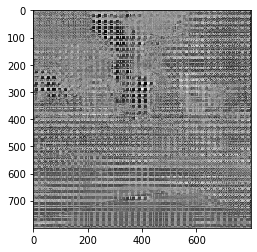

In [19]:
plt.imshow(output[0].cpu().numpy(),cmap='binary')

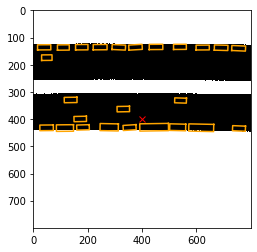

In [24]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb.view(2,4).cpu(), color=color_list[2]) 

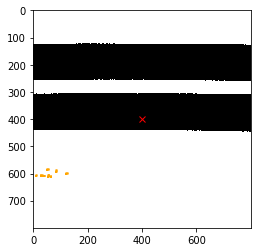

In [21]:
fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image, cmap ='binary')
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(cars):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb.view(2,4).cpu(), color=color_list[2]) 

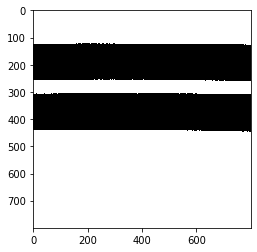

In [47]:
plt.imshow(road_image, cmap='binary')

## Extra Info

There is some extra information you can use in your model, but it is optional.

# Visualize the bounding box

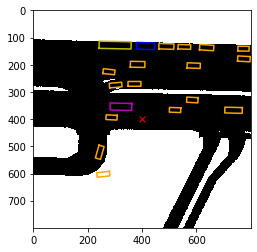

In [56]:
# The center of image is 400 * 400

fig, ax = plt.subplots()

color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']

ax.imshow(road_image[0], cmap ='binary');

# The ego car position
ax.plot(400, 400, 'x', color="red")

for i, bb in enumerate(target[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works 
    draw_box(ax, bb, color=color_list[target[0]['category'][i]])    

# Evaluation
During the whole competition, you have three submission deadlines. The dates will be announced on Piazza. You will have to fill up the template 'data_loader.py' for evaluation. (see the comment inside data_loader.py' for more information)

There will be two leaderboards for the competition:
The leaderboard for binary road map.
We will evaluate your model's performance by using the average threat score (TS) across the test set:
$$\text{TS} = \frac{\text{TP}}{\text{TP} + \text{FP} + \text{FN}}$$
The leaderboard for object detection:
We will evaluate your model's performance for object detection by using the average mean threat score at different intersection over union (IoU) thresholds.
There will be five different thresholds (0.5, 0.6, 0.7, 0.8, 0.9). For each thresholds, we will calculate the threat score. The final score will be a weighted average of all the threat scores:
$$\text{Final Score} = \sum_t \frac{1}{t} \cdot \frac{\text{TP}(t)}{\text{TP}(t) + \text{FP}(t) + \text{FN}(t)}$$
